In [1]:
import pandas as pd
import geopandas as gp 
import json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import networkx as nx
sns.set(rc={'figure.figsize':(12,8)})
%matplotlib inline
from tqdm import tqdm
import glob
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import linregress

In [2]:
train = pd.read_csv('scratchpad/drugsComTrain_raw.tsv',sep = '\t')
test = pd.read_csv('scratchpad/drugsComTest_raw.tsv',sep = '\t')
total = pd.concat([train, test])
total = total.dropna()
drug_disease_dict = {}
for name , group in total.groupby('condition'):
    if '</span>' not in name:
        drug_disease_dict[name] = list(group['drugName'].unique())

In [3]:
drug_disease_dict

{'ADHD': ['Guanfacine',
  'Daytrana',
  'Intuniv',
  'Focalin',
  'Vyvanse',
  'Lisdexamfetamine',
  'Amphetamine / dextroamphetamine',
  'Atomoxetine',
  'Concerta',
  'Strattera',
  'Focalin XR',
  'Methylphenidate',
  'Ritalin',
  'Kapvay',
  'Adderall',
  'Bupropion',
  'Dexmethylphenidate',
  'Wellbutrin SR',
  'Zenzedi',
  'Desoxyn',
  'Adderall XR',
  'Adzenys XR-ODT',
  'Pemoline',
  'Nuvigil',
  'Dyanavel XR',
  'Dextroamphetamine',
  'Methylin ER',
  'Dexedrine',
  'Amphetamine',
  'Quillivant XR',
  'Omega-3 polyunsaturated fatty acids',
  'Mydayis',
  'Clonidine',
  'Catapres',
  'Ritalin LA',
  'ProCentra',
  'Methylin',
  'Metadate CD',
  'Amantadine',
  'Wellbutrin',
  'Modafinil',
  'Methamphetamine',
  'Wellbutrin XL',
  'Ritalin-SR',
  'Armodafinil',
  'Evekeo',
  'Cylert',
  'Aptensio XR',
  'Desipramine',
  'Imipramine',
  'Tenex',
  'Provigil',
  'Selegiline',
  'Pristiq',
  'Desvenlafaxine',
  'Metadate ER',
  'Budeprion XL',
  'Dextrostat'],
 'AIDS Related Wastin

In [4]:
files = glob.glob('../BL_Work/openPrescribe/serialized/*.gz')
print(files)

['../BL_Work/openPrescribe/serialized/201810.gz', '../BL_Work/openPrescribe/serialized/201710.gz', '../BL_Work/openPrescribe/serialized/201203.gz', '../BL_Work/openPrescribe/serialized/201110.gz', '../BL_Work/openPrescribe/serialized/201804.gz', '../BL_Work/openPrescribe/serialized/201308.gz', '../BL_Work/openPrescribe/serialized/201708.gz', '../BL_Work/openPrescribe/serialized/201211.gz', '../BL_Work/openPrescribe/serialized/201707.gz', '../BL_Work/openPrescribe/serialized/201803.gz', '../BL_Work/openPrescribe/serialized/201410.gz', '../BL_Work/openPrescribe/serialized/201301.gz', '../BL_Work/openPrescribe/serialized/201201.gz', '../BL_Work/openPrescribe/serialized/201409.gz', '../BL_Work/openPrescribe/serialized/201812.gz', '../BL_Work/openPrescribe/serialized/201603.gz', '../BL_Work/openPrescribe/serialized/201109.gz', '../BL_Work/openPrescribe/serialized/201512.gz', '../BL_Work/openPrescribe/serialized/201601.gz', '../BL_Work/openPrescribe/serialized/201101.gz', '../BL_Work/openPre

In [6]:
#Different functions to extract different data form the prescription 

def cleanStringofUTF(string):
    cleaned = string.replace('\xe8','e').replace('\xf6','o')
    return cleaned

def enrichdrugs(chem_dict , drugs):
    diabetes_drug_words = [drugs[k]['name'].lower() for k in drugs]
    for drug in chem_dict:
        Name = chem_dict[drug]['name'].replace('(','').replace(')','')
        slot1 = Name.lower().split('/')
        slot2 = Name.lower().split(' ')
        slot3 = Name.lower().split(' & ')
        common1 = set(diabetes_drug_words).intersection(slot1)
        common2 = set(diabetes_drug_words).intersection(slot2)
        common3 = set(diabetes_drug_words).intersection(slot3)
        
        if len(common1) > 0 or len(common2) > 0 or len(common3) > 0:
            print(common1 , common2 , common3)
            drugs[chem_dict[drug]['code']] = {'disease':'' , 'disease_given_drug':0.0 , 'matched_disease':'', 'name':chem_dict[drug]['name'].strip() }

            
            
def makeChemDict(BNF_Chem):
    chem_dict = {}
    for index, row in BNF_Chem.iterrows():
        chem_dict[row['UNII_drugbank']] = {}
        chem_dict[row['UNII_drugbank']]['name'] = row['NAME']
        chem_dict[row['UNII_drugbank']]['code'] = row['BNF_code']
    return chem_dict
    
def getDrugCategory(categorylist, BNF_Chem, drugbankDict):
    allMatched = []
    drugs = {}
    chem_dict = makeChemDict(BNF_Chem)
    
    for k in drugbankDict:
        if len(drugbankDict[k]['Categories']) > 0:
            for cat in drugbankDict[k]['Categories']:
                matched_memo = []
                catString = cat.values()[0]#.split('\u2014')[-1]
                t = catString.lower().strip()
                for categoryString in categorylist:
                    categoryString = categoryString.lower()
                    if t.find(categoryString) >= 0:
                        matched_memo.append(categoryString)
                if k in chem_dict:
                    if len(matched_memo) > 0:# == len(categorylist):
                        allMatched.append(k)
                        print (chem_dict[k])
                        drugs[chem_dict[k]['code']] = {}
                        drugs[chem_dict[k]['code']]['name'] = chem_dict[k]['name']
                        drugs[chem_dict[k]['code']]['matched_cat'] = categorylist
    enrichdrugs(chem_dict,drugs)               
    return list(set(allMatched)) , drugs


def getDrugforDiseaseDrugbank(categorylist, BNF_Chem, drugbankDict):
    allMatched = []
    drugs = {}
    chem_dict = makeChemDict(BNF_Chem)
    
    for k in drugbankDict:
        if len(drugbankDict[k]['Associations']) > 0:
            for cat in drugbankDict[k]['Associations']:
                matched_memo = []
                catString = cat.values()[0]
                t = catString.lower().strip()
                for categoryString in categorylist:
                    categoryString = categoryString.lower()
                    if t.find(categoryString) >= 0:
                        matched_memo.append(categoryString)
                if k in chem_dict:
                    if len(matched_memo) > 0:
                        allMatched.append(k)
                        print (chem_dict[k])
                        drugs[chem_dict[k]['code']] = {}
                        drugs[chem_dict[k]['code']]['name'] = chem_dict[k]['name']
                        drugs[chem_dict[k]['code']]['matched_cat'] = categorylist
    enrichdrugs(chem_dict,drugs)               
    return  allMatched , drugs


# def createDrugList(disease , drugs, BNF_Chem, drugbankDict):
#     allMatched = []
#     drugs = {}
#     chem_dict = makeChemDict(BNF_Chem)
    
#     for k in drugbankDict:
#         if k in chem
      
#         drugs[chem_dict[k]['code']] = {}
#         drugs[chem_dict[k]['code']]['name'] = chem_dict[k]['name']
#         drugs[chem_dict[k]['code']]['matched_cat'] = categorylist
#     enrichdrugs(chem_dict,drugs)               
#     return  allMatched , drugs


def findDrugsForDisease(Graph, Disease, BNF_Chem ):#,threshProb):
    chem_dict = makeChemDict(BNF_Chem)
    drugs = {}
    for e in Graph.edges(data=True):
        if (cleanStringofUTF(e[1]).lower().find(Disease.lower()) >=0) or (cleanStringofUTF(e[0]).lower().find(Disease.lower()) >= 0) :
            drugNode = ''
            matchedDisease = ''
            if Graph.node[e[0]]['type'] == 'symptom':
                drugNode = e[1]
                matchedDisease = e[0]
            else:
                drugNode = e[0]
                matchedDisease = e[1]
            drugs[Graph.node[drugNode]['Id']] = {}
            drugs[Graph.node[drugNode]['Id']]['name'] = drugNode
            drugs[Graph.node[drugNode]['Id']]['matched_disease'] = matchedDisease
            drugs[Graph.node[drugNode]['Id']]['disease'] = Disease
    enrichdrugs(chem_dict,drugs)
    return drugs


def generateConfidence(drugs,Graph):
    shared = []
    All = []
    denom = max(Graph.degree().values())
    for d in drugs:
        name = drugs[d]['name']
        for e in Graph.edges(data=True):
            if Graph.node[e[0]]['type'] == 'symptom':
                if e[1] == name:
                    shared.append(Graph.degree()[e[1]]-1)
                else:
                    continue
            else:
                
                if e[0] == name:
                    shared.append(Graph.degree()[e[0]]-1)
                else:
                    continue
#     shared = [float(k) for k in shared]
    num = [k for k in shared if k > 1]

    return float(len(num)+1.0)/float(len(shared)+1.0)
#     return float(len(num))/float(len(shared)) * 10.0
#     return len(num)
                
                
def findDrugsForCategory(Graph, Cat, BNF_Chem ):#,threshProb):
    chem_dict = makeChemDict(BNF_Chem)
    drugs = {}
    for e in Graph.edges(data=True):
        if (cleanStringofUTF(e[1]).lower().find(Cat.lower()) >=0) or (cleanStringofUTF(e[0]).lower().find(Cat.lower()) >= 0) :
            drugNode = ''
            matchedDisease = ''
            if Graph.node[e[0]]['type'] == 'category':
                drugNode = e[1]
                matchedDisease = e[0]
            else:
                drugNode = e[0]
                matchedDisease = e[1]
            print (Graph.node[drugNode]['Id'])
            drugs[Graph.node[drugNode]['Id']] = {}
            drugs[Graph.node[drugNode]['Id']]['name'] = drugNode
            drugs[Graph.node[drugNode]['Id']]['matched_cat'] = matchedDisease
            drugs[Graph.node[drugNode]['Id']]['category'] = Cat
    enrichdrugs(chem_dict,drugs)
    return drugs

def findDrugByName(Graph, name):
    foundDrugs = []
    for node in Graph.nodes(data=True):
        if node[1]['type'] == 'drug':
            if name.lower() in node[0].lower().split(' '):
                foundDrugs.append(node)
    return foundDrugs

def relabelNodes(graph):
    mapping = {}
    for node in graph.nodes():
        mapping[node] = cleanStringofUTF(node)
        
    return nx.relabel_nodes(graph,mapping)


def readChem(year,files):
    for f in files:
        if f.find(year)>0:
            if f.find('CHEM') > 0:
                df = pd.read_csv(f,compression='infer',header=None,skiprows=1)
                return df

def readAddress(year,files):
    for f in files:
        if f.find(year)>0:
            if f.find('ADDR') > 0:
                df = pd.read_csv(f,compression='infer',header=None,skiprows=1)
                return df

def readPrescriptions(year,files):
    for f in files:
        if f.find(year)>0:
            if f.find('PDPI') > 0:
                df = pd.read_csv(f,compression='infer',header=None,skiprows=1)
                return df

In [7]:
with open('scratchpad/Bipartite_Drug_graph.pkl','rb') as f:
    drug_association_graph  = pkl.load(f)

with open('scratchpad/Bipartite_Drug_category_graph.pkl','rb') as f:
    drug_cat_association_graph  = pkl.load(f)

In [8]:
#Get manually curated disease drug associaltions

drug_associations_adam = pd.read_csv('scratchpad/heatwave_diseases_drugs.tsv', sep = '\t',header = None)

In [9]:

drug_associations_adam.head()

,0,1
0,Acute Anxiety,Bromazepam
1,Acute Anxiety,Chlordiazepoxide
2,Acute Anxiety,Hydroxyzine
3,Acute Coronary Events,Pravastatin
4,Acute Coronary Syndrome,Clopidogrel


In [10]:
print len(drug_association_graph.edges()) 
print len(drug_cat_association_graph.edges())
print len(drug_association_graph.nodes()) 
print len(drug_cat_association_graph.nodes())

7954
33493
4029
4047


In [11]:
drugbank_dict = json.load(open('scratchpad/Drugbank_drugs_data.json','rb'))
# chem = readChem('201601',files)
chem = pd.read_csv('../BL_Work/CHEM_MASTER_MAP.csv')
len(chem)

# chem = chem.dropna()

matched = chem[chem['UNII_drugbank']!='[]']

matchedMap = {}
for index,row in matched.iterrows():
    if row['UNII_drugbank'] not in matchedMap:
         matchedMap[row['UNII_drugbank']] = []
    matchedMap[row['UNII_drugbank']].append(row['BNF_code'])

In [27]:
matchedMap

{'JCV8365FWN': ['0206040AR'],
 '8KQ660G60G': ['0602020D0'],
 'O9U0F09D5X': ['0402010G0'],
 '0CD5FD6S2M': ['1304000N0'],
 '27Y3KJK423': ['0301030B0', '0301030C0', '0301030D0'],
 'LW0TIW155Z': ['1001010X0'],
 'Z633861EIM': ['0908010AM'],
 'MZ1IW7Q79D': ['0503021A0'],
 '5D06587D6R': ['0406000AB'],
 'J4ZHN3HBTE': ['0206020N0'],
 'S915P5499N': ['0901070B0'],
 'E89I1637KE': ['0601023I0'],
 'Q94YYU22B8': ['0405020E0'],
 '9100L32L2N': ['0601022B0'],
 '3G6A5W338E': ['0309020F0',
  '0404000D0',
  '0404000E0',
  '0407010AA',
  '0407010U0'],
 'CUB7JI0JV3': ['1203030D0', '1203040C0'],
 '742SXX0ICT': ['0205010Z0', '0704050R0'],
 'N0A3Z5XTC6': ['1105000S0'],
 '1XU104G55N': ['0212000AD'],
 '42H8PQ0NMJ': ['0206040AE'],
 '62XCK0G93T': ['0501110N0'],
 '61JJC8N5ZK': ['0504050T0'],
 'WV5EC51866': ['0405020S0'],
 '5Y5F15120W': ['0605010R0'],
 'GWH6IJ239E': ['0401030C0', '0401030E0'],
 'MDY902UXSR': ['020400070'],
 '953A26OA1Y': ['0307000K0'],
 'GNN1DV99GX': ['1001030F0'],
 'KXO2KT9N0G': ['0212000X0'],
 'L6O

In [12]:
for k in drugbank_dict:
    name  = drugbank_dict[k]['Name']
    for l in drug_disease_dict:
        drugs = drug_disease_dict[l]
        cleaned_drugs = [x.replace('/','') for x in drugs]
        if name in cleaned_drugs:
            entry = {'/indications/DCOM':l}
            drugbank_dict[k]['Associations'].append(entry)

In [13]:
indication_List = {'Drug' : [] , 'Association':[]}

for k in drugbank_dict:
    name =  drugbank_dict[k]['Name']
    if len(drugbank_dict[k]['Associations']) > 0:
        for condition in drugbank_dict[k]['Associations']:
            condition_name = condition[condition.keys()[0]]
            indication_List['Drug'].append(name)
            indication_List['Association'].append(condition_name.encode('utf-8'))
            


In [14]:
indication_df = pd.DataFrame.from_dict(indication_List)
indication_df.to_csv('Disease_drug_map.csv')

In [30]:
# indication_df

In [15]:
condition_Association_map = {}
for k in drugbank_dict:
    if len(drugbank_dict[k]['Associations']) > 0:
        for ass in drugbank_dict[k]['Associations']:
            
            disease = ass[ass.keys()[0]]
            if disease not in condition_Association_map:
                condition_Association_map[disease] = []
            condition_Association_map[disease].append(drugbank_dict[k]['Name'])
    

category_Association_map = {}
for k in drugbank_dict:
    if len(drugbank_dict[k]['Categories']) > 0:
        for ass in drugbank_dict[k]['Categories']:
            
            disease = ass[ass.keys()[0]]
            if disease not in category_Association_map:
                category_Association_map[disease] = []
            category_Association_map[disease].append(drugbank_dict[k]['Name'])

In [50]:
drugbank_dict

{u'JWF5YAW3QW': {u'ATC_Codes': [{u'/atc/N05CM09': u'N05CM09 \u2014 Valerianae radix'},
   {u'/atc/N05CM': u'N05CM \u2014 Other hypnotics and sedatives'},
   {u'/atc/N05C': u'N05C \u2014 HYPNOTICS AND SEDATIVES'},
   {u'/atc/N05': u'N05 \u2014 PSYCHOLEPTICS'},
   {u'/atc/N': u'N \u2014 NERVOUS SYSTEM'}],
  u'Associations': [{'/indications/DCOM': 'Insomnia'}],
  u'Categories': [{u'/categories/DBCAT000399': u'Central Nervous System Depressants'},
   {u'/categories/DBCAT003727': u'Herbs and Natural Products'},
   {u'/categories/DBCAT000452': u'Hypnotics and Sedatives'},
   {u'/categories/DBCAT003678': u'Miscellaneous Anxiolytics Sedatives and Hypnotics'},
   {u'/categories/DBCAT002148': u'Nervous System'},
   {u'/categories/DBCAT002185': u'Psycholeptics'}],
  u'Name': u'Valerian'},
 u'JCV8365FWN': {u'ATC_Codes': [{u'/atc/C04AE02': u'C04AE02 \u2014 Nicergoline'},
   {u'/atc/C04AE': u'C04AE \u2014 Ergot alkaloids'},
   {u'/atc/C04A': u'C04A \u2014 PERIPHERAL VASODILATORS'},
   {u'/atc/C04': 

In [16]:
commonKeys = set(drugbank_dict.keys()).intersection(matchedMap.keys())

category_BNF_map = {}
for k in commonKeys:
    if len(drugbank_dict[k]['Categories']) > 0:
        for ass in drugbank_dict[k]['Categories']:
            
            disease = ass[ass.keys()[0]]
            if disease not in category_BNF_map:
                category_BNF_map[disease] = []
            BNF_code = matched
            category_BNF_map[disease]+=matchedMap[k]

In [83]:
def extractATC(ATC_list):
    topLevel = ATC_list[0]
    ATC_string = list(topLevel.keys())[0]
    return str(ATC_string.split('/')[-1])

def extractEntityList(Category_list):
    cat_list = []
    for item in Category_list:
        cat = list(item.values())[0]
        cat_list.append(cat)
    return ' : '.join([w.encode('utf-8') for w in cat_list])


In [84]:
extractATC(drugbank_dict['5RXY50Q01N']['ATC_Codes'])
extractEntityList(drugbank_dict['5RXY50Q01N']['Categories'])
extractEntityList(drugbank_dict['O9U0F09D5X']['Associations'])

'Acute Agitation : Chemotherapy-Induced Nausea and Vomiting (CINV) : Delirium : Nausea and vomiting : Nausea/Vomiting'

In [85]:
matched_drugDf = {'BNF_code':[] , 'UNII_code':[] , 'ATC_code' : [] ,'Drug_name' : [] , 'Drug_category' : [] , 'Conditions' : []}
for k in matchedMap:
    codes = matchedMap[k]
    for c in codes:
        matched_drugDf['BNF_code'].append(c)
        matched_drugDf['UNII_code'].append(k)
        matched_drugDf['Drug_name'].append(drugbank_dict[k]['Name'])
        matched_drugDf['ATC_code'].append(extractATC(drugbank_dict[k]['ATC_Codes']))
        matched_drugDf['Drug_category'].append(extractEntityList(drugbank_dict[k]['Categories']))
        matched_drugDf['Conditions'].append(extractEntityList(drugbank_dict[k]['Associations']))
                                          
        

In [91]:
MappingDf = pd.DataFrame.from_dict(matched_drugDf)
MappingDf.BNF_code = MappingDf.BNF_code.astype(str)

In [92]:
MappingDf[:100]

,ATC_code,BNF_code,Conditions,Drug_category,Drug_name,UNII_code
0,C04AE02,0206040AR,,Adrenergic Agents : Adrenergic alpha-1 Recepto...,Nicergoline,JCV8365FWN
1,H03BB01,0602020D0,,Agents Causing Muscle Toxicity : Antithyroid a...,Carbimazole,8KQ660G60G
2,N05AD08,0402010G0,Acute Agitation : Chemotherapy-Induced Nausea ...,"Adjuvants, Anesthesia : Adrenergic alpha-1 Rec...",Droperidol,O9U0F09D5X
3,S01CA10,1304000N0,Atopic Dermatitis (AD) : Dermatosis : Diabetic...,Adrenal Cortex Hormones : Agents for Treatment...,Fluocinolone acetonide,0CD5FD6S2M
4,R03DA55,0301030B0,Acute Exacerbation of Chronic Bronchitis (AECB...,Agents that reduce seizure threshold : Alkaloi...,Aminophylline,27Y3KJK423
5,R03DA55,0301030C0,Acute Exacerbation of Chronic Bronchitis (AECB...,Agents that reduce seizure threshold : Alkaloi...,Aminophylline,27Y3KJK423
6,R03DA55,0301030D0,Acute Exacerbation of Chronic Bronchitis (AECB...,Agents that reduce seizure threshold : Alkaloi...,Aminophylline,27Y3KJK423
7,M01AX01,1001010X0,Osteoarthritis (OA) : Rheumatoid Arthritis : M...,Agents causing hyperkalemia : Agents that prod...,Nabumetone,LW0TIW155Z
8,A16AB13,0908010AM,Infantile-onset Hypophosphatasia : Juvenile-on...,"Alimentary Tract and Metabolism : Amino Acids,...",Asfotase alfa,Z633861EIM
9,J05AB11,0503021A0,CMV Infections : Chickenpox : Genital Herpes :...,Acyclovir : Acyclovir and prodrug : Amino Acid...,Valaciclovir,MZ1IW7Q79D


In [93]:
MappingDf.to_csv('scratchpad/prescription_mapping_v1.csv')

In [88]:
category_BNF_map

{u'Curare Alkaloids': ['1501050C0', '1501050S0'],
 u'Breast Cancer Resistance Protein Inhibitors': ['0802040AI',
  '0503032H0',
  '0503010G0',
  '0503010U0',
  '0503032G0',
  '0502000M0',
  '0502010C0',
  '0503010AI',
  '0503010AK',
  '0503010AL',
  '0501070AD',
  '0901040C0',
  '0503032E0'],
 u'Prostacyclin Analogues': ['0205010V0'],
 u'UGT1A1 Substrates': ['0801040D0',
  '0602010V0',
  '0503010E0',
  '0503010AE',
  '1501010L0',
  '0407020B0',
  '0410030A0',
  '1002020H0',
  '0801050BJ',
  '0212000L0',
  '0212000M0',
  '0212000P0',
  '020400080',
  '1001010P0',
  '100101070',
  '0408010H0',
  '0204000I0',
  '1501070G0',
  '1902070Q0',
  '0901030K0',
  '040702040',
  '0604011D0',
  '0702010E0',
  '0703010E0',
  '0703010F0',
  '0703010G0',
  '0703010H0',
  '0703010I0',
  '0703010P0',
  '0703010Q0',
  '0408010AD',
  '0212000B0',
  '1001010L0',
  '100302010',
  '0212000C0',
  '1001010I0',
  '1104020G0',
  '0410030E0',
  '0402030Q0',
  '040801020',
  '0601021P0',
  '0803041AA',
  '0503010A

In [46]:
# drugbank_dict

In [47]:
# condition_Association_map

In [48]:
# category_BNF_map

In [37]:
adam_disease_drug_list = {}
for name , group in drug_associations_adam.groupby(0):
    adam_disease_drug_list[name] = list(group[1])

In [98]:
chem[chem['BNF_code'] == '0206040AB']

,Unnamed: 0,BNF_code,NAME,UNII_drugbank
411,411,0206040AB,Calcium Dobesilate ...,SY7Q814VUP


In [20]:
opiod_matched , drugs_opiates = getDrugforDiseaseDrugbank(['Heart condition'],chem,drugbank_dict)

In [21]:
opiod_matched , drugs_opiates =getDrugCategory(['kidney'],chem,drugbank_dict)

{'code': '0307000R0', 'name': 'Mannitol                                                    '}
{'code': '0905022T0', 'name': 'Lanthanum Carbonate                                         '}
(set(['mannitol                                                    ']), set([]), set(['mannitol                                                    ']))
(set(['lanthanum carbonate                                         ']), set([]), set(['lanthanum carbonate                                         ']))


In [50]:
selected_diseases = ['fever']
disease_match_dict = {}
for d in selected_diseases:
    disease_match_dict[d] = {}
    matched, drugs  = getDrugforDiseaseDrugbank([d] ,chem,drugbank_dict)
    disease_match_dict[d] = drugs

{'code': '1001030C0', 'name': 'Hydroxychloroquine Sulfate                                  '}
{'code': '0605010T0', 'name': 'Tetracosactide                                              '}
{'code': '1201020Q0', 'name': 'Ciprofloxacin/Dexameth                                      '}
{'code': '100101070', 'name': 'Naproxen Sodium                                             '}
{'code': '0501011P0', 'name': 'Phenoxymethylpenicillin (Penicillin V)                      '}
{'code': '0501011P0', 'name': 'Phenoxymethylpenicillin (Penicillin V)                      '}
{'code': '1310011Y0', 'name': 'Silver Sulfadiazine                                         '}
{'code': '1310011Y0', 'name': 'Silver Sulfadiazine                                         '}
{'code': '1306020K0', 'name': 'Doxycycline Monohydrate                                     '}
{'code': '1306020K0', 'name': 'Doxycycline Monohydrate                                     '}
{'code': '1306020K0', 'name': 'Doxycycline Monohydrate      

In [51]:
disease_match_dict

{'fever': {'0501011P0': {'matched_cat': ['fever'],
   'name': 'Phenoxymethylpenicillin (Penicillin V)                      '},
  '0501022D0': {'disease': '',
   'disease_given_drug': 0.0,
   'matched_disease': '',
   'name': 'Imipenem With Cilastatin'},
  '0501030F0': {'disease': '',
   'disease_given_drug': 0.0,
   'matched_disease': '',
   'name': 'Demeclocycline Hydrochloride'},
  '0605010T0': {'disease': '',
   'disease_given_drug': 0.0,
   'matched_disease': '',
   'name': 'Tetracosactide'},
  '100101070': {'disease': '',
   'disease_given_drug': 0.0,
   'matched_disease': '',
   'name': 'Naproxen Sodium'},
  '1001030C0': {'disease': '',
   'disease_given_drug': 0.0,
   'matched_disease': '',
   'name': 'Hydroxychloroquine Sulfate'},
  '1001040G0': {'disease': '',
   'disease_given_drug': 0.0,
   'matched_disease': '',
   'name': 'Colchicine'},
  '1003020P0': {'disease': '',
   'disease_given_drug': 0.0,
   'matched_disease': '',
   'name': 'Ibuprofen'},
  '1103010R0': {'disease':

In [59]:
name_unii_map = {drugbank_dict[k]['Name'] : k for k in drugbank_dict}

In [60]:
name_unii_map

{u'Fluciclovine (18F)': u'38R1Q0L1ZE',
 u'Doxofylline': u'MPM23GMO7Z',
 u'Caffeine': u'3G6A5W338E',
 u'Sparfloxacin': u'Q90AGA787L',
 u'Dalfampridine': u'BH3B64OKL9',
 u'Undecylenic acid': u'K3D86KJ24N',
 u'Atenolol': u'50VV3VW0TI',
 u'Yttrium Y-90': u'1K8M7UR6O1',
 u'Gemfibrozil': u'Q8X02027X3',
 u'Azapropazone': u'K2VOT966ZI',
 u'Ferric (59Fe) citrate': u'5171JCI1D5',
 u'Meclofenoxate': u'C76QQ2I0RG',
 u'Fostamatinib': u'SQ8A3S5101',
 u'Enflurane': u'91I69L5AY5',
 u'Dropropizine': u'U0K8WHL37U',
 u'Atosiban': u'081D12SI0Z',
 u'Ditazole': u'H2BQI5Z8FT',
 u'Acyclovir': u'X4HES1O11F',
 u'Methazolamide': u'W733B0S9SD',
 u'Cinepazet': u'0LC95WWE9Q',
 u'Clopamide': u'17S83WON0I',
 u'Tasimelteon': u'SHS4PU80D9',
 u'Troxipide': u'W6QJX1Q00Z',
 u'Camostat': u'0FD207WKDU',
 u'Glutathione': u'GAN16C9B8O',
 u'Vosaroxin': u'K6A90IIZ19',
 u'Stannous fluoride': u'3FTR44B32Q',
 u'Ferrous glycine sulfate': u'56PS9HY5XI',
 u'Butriptyline': u'Z22441975X',
 u'L-Arginine': u'94ZLA3W45F',
 u'Aluminum chlo

limit_output extension: Maximum message size of 10000 exceeded with 33109 characters

In [79]:
disease_drug_dict_adam = {}
for k in adam_disease_drug_list:
    disease_drug_dict_adam[k] = {}
    for d in adam_disease_drug_list[k]:
        if d in name_unii_map:
            if name_unii_map[d] in matchedMap:
                for bnf in matchedMap[name_unii_map[d]]:
                    disease_drug_dict_adam[k][bnf] = {}
                    disease_drug_dict_adam[k][bnf]['matched_disease'] = k       
                    disease_drug_dict_adam[k][bnf]['name'] = d
# print disease_drug_dict
    

In [80]:
disease_drug_dict_adam['Cerebrovascular Insufficiency']

{'0206040AP': {'matched_disease': 'Cerebrovascular Insufficiency',
  'name': 'Isoxsuprine'},
 '0701030I0': {'matched_disease': 'Cerebrovascular Insufficiency',
  'name': 'Isoxsuprine'}}

In [72]:
pdp = pd.read_csv('../BL_Work/openPrescribe/serialized/201601.gz',compression='gzip')
pdp.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,1962,Q44,01C,N81002,0101010G0BBABAB,Maalox_Susp 195mg/220mg/5ml S/F,1.0,3.35,3.11,500.0,...,NaN,NaN,NaN,NaN,220.0,0101010G0,500.0,1.0,500.0,BB
1,1963,Q44,01C,N81002,0101010G0BCABAB,Mucogel_Susp 195mg/220mg/5ml S/F,1.0,2.99,2.77,500.0,...,NaN,NaN,NaN,NaN,220.0,0101010G0,500.0,1.0,500.0,BC
2,1964,Q44,01C,N81002,0101021B0AAALAL,Sod Algin/Pot Bicarb_Susp S/F,4.0,30.72,28.42,3000.0,...,NaN,NaN,NaN,NaN,0.0,0101021B0,3000.0,1.0,3000.0,AA
3,1965,Q44,01C,N81002,0101021B0AAAPAP,Sod Alginate/Pot Bicarb_Tab Chble 500mg,2.0,9.21,8.53,180.0,...,NaN,NaN,NaN,NaN,500.0,0101021B0,180.0,1.0,180.0,AA
4,1966,Q44,01C,N81002,0101021B0BEACAH,Gaviscon_Liq Orig Aniseed Relief,2.0,20.10,18.59,1500.0,...,NaN,NaN,NaN,NaN,0.0,0101021B0,1500.0,1.0,1500.0,BE


In [73]:
def getDate(elem):
    f = elem.split('/')[-1]
    return int(f.split('.')[0])

In [74]:
files.sort(key=getDate)
files

['../BL_Work/openPrescribe/serialized/201008.gz',
 '../BL_Work/openPrescribe/serialized/201009.gz',
 '../BL_Work/openPrescribe/serialized/201010.gz',
 '../BL_Work/openPrescribe/serialized/201011.gz',
 '../BL_Work/openPrescribe/serialized/201012.gz',
 '../BL_Work/openPrescribe/serialized/201101.gz',
 '../BL_Work/openPrescribe/serialized/201102.gz',
 '../BL_Work/openPrescribe/serialized/201103.gz',
 '../BL_Work/openPrescribe/serialized/201104.gz',
 '../BL_Work/openPrescribe/serialized/201105.gz',
 '../BL_Work/openPrescribe/serialized/201106.gz',
 '../BL_Work/openPrescribe/serialized/201107.gz',
 '../BL_Work/openPrescribe/serialized/201108.gz',
 '../BL_Work/openPrescribe/serialized/201109.gz',
 '../BL_Work/openPrescribe/serialized/201110.gz',
 '../BL_Work/openPrescribe/serialized/201111.gz',
 '../BL_Work/openPrescribe/serialized/201112.gz',
 '../BL_Work/openPrescribe/serialized/201201.gz',
 '../BL_Work/openPrescribe/serialized/201202.gz',
 '../BL_Work/openPrescribe/serialized/201203.gz',


In [75]:
%store -r taxonomyDict

In [76]:
%store -r cityMap

In [78]:
ward_pop1 = pd.read_csv('scratchpad/ward_pop.csv')

/home/sagar/anaconda3/envs/env_py2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (23,24,25,26,27,28,29,30,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [81]:
taxonomy = pd.read_csv('../BL_Work/openPrescribe/taxonomy/openprescription_taxonomy',sep='\t')

In [82]:
ward_pop = pd.read_csv('../BL_Work/mid_2010_ward_2010_quinary.csv')

In [83]:
GP_META = pd.read_csv('../BL_Work/epraccur.csv',header=None)
GP_META.rename(columns={0:'BP_code',
                        1:'Name',
                        2:'Grouping',
                        3:'National_geo',
                        4:'Addr1',
                        5:'Addr2',
                        6:'Addr3',
                        7: 'Addr4',
                        8:'Addr5',
                        9:'Postcode',
                        10:'Open',
                        11:'Closed',
                        12:'Status',
                        13:'Org type code',
                        14:'Commissioner',
                        15:'Join provider',
                        16:'Left provider',
                        17:'Contact',
                        18:'Null1',
                        19:'Null2',
                        20:'Null3',
                        21:'Amended',
                        22:'Null4',
                        23:'Provider',
                        24:'Null5',
                        25:'Setting',
                        26:'Null6'}, 
                 inplace=True)

In [84]:
GP_META.head()

,BP_code,Name,Grouping,National_geo,Addr1,Addr2,Addr3,Addr4,Addr5,Postcode,...,Contact,Null1,Null2,Null3,Amended,Null4,Provider,Null5,Setting,Null6
0,A81001,THE DENSHAM SURGERY,Y63,Q74,THE HEALTH CENTRE,LAWSON STREET,STOCKTON-ON-TEES,CLEVELAND,NaN,TS18 1HU,...,01642 672351,NaN,NaN,NaN,1,NaN,00K,NaN,4,NaN
1,A81002,QUEENS PARK MEDICAL CENTRE,Y63,Q74,QUEENS PARK MEDICAL CTR,FARRER STREET,STOCKTON ON TEES,CLEVELAND,NaN,TS18 2AW,...,01642 679681,NaN,NaN,NaN,1,NaN,00K,NaN,4,NaN
2,A81003,VICTORIA MEDICAL PRACTICE,Y54,Q74,THE HEALTH CENTRE,VICTORIA ROAD,HARTLEPOOL,CLEVELAND,NaN,TS26 8DB,...,01429 272945,NaN,NaN,NaN,0,NaN,00K,NaN,4,NaN
3,A81004,BLUEBELL MEDICAL CENTRE,Y63,Q74,TRIMDON AVENUE,ACKLAM,MIDDLESBROUGH,NaN,NaN,TS5 8SB,...,01642 827697,NaN,NaN,NaN,1,NaN,00M,NaN,4,NaN
4,A81005,SPRINGWOOD SURGERY,Y63,Q74,SPRINGWOOD SURGERY,RECTORY LANE,GUISBOROUGH,NaN,NaN,TS14 7DJ,...,01287 619611,NaN,NaN,NaN,1,NaN,00M,NaN,4,NaN


In [85]:
Open_filtered_GPs = {}
for index,row in GP_META.iterrows():
    if row ['Setting'] == 4 and row['Status'] =='A':
        Open_filtered_GPs[row['BP_code']] = row['Postcode'].strip()

In [86]:
len(Open_filtered_GPs)

6924

In [87]:
df_city = pd.read_csv('../BL_Work/Lower_Layer_Super_Output_Area_2011_to_Ward_2017_Lookup_in_England_and_Wales.csv')

In [88]:
df_city.head()

,LSOA11CD,LSOA11NM,WD17CD,WD17NM,WD17NMW,LAD17CD,LAD17NM,FID
0,E01000001,City of London 001A,E05009288,Aldersgate,NaN,E09000001,City of London,1
1,E01000205,Barnet 035A,E05000052,Garden Suburb,NaN,E09000003,Barnet,2
2,E01000002,City of London 001B,E05009302,Cripplegate,NaN,E09000001,City of London,3
3,E01000003,City of London 001C,E05009302,Cripplegate,NaN,E09000001,City of London,4
4,E01000206,Barnet 033B,E05000052,Garden Suburb,NaN,E09000003,Barnet,5


In [89]:
wardMap = {}
for name , group in df_city.groupby('WD17CD'):
        wardMap[name] = list(group['LSOA11CD'])

In [90]:
LSOA_survey_takers = json.load(open('scratchpad/LSOA_suvery_pop.json'))

In [91]:
population = {}
for index, row in ward_pop1.iterrows():
    if not row['All Ages'] == '..':
        if isinstance(row['All Ages'],str):
            population[row['Ward Code 1']] = float(row['All Ages'].replace(',',''))


In [92]:
len(population)

8297

In [93]:
sum(population.values())

58381217.0

In [94]:
len(set(wardMap.keys()).intersection(population.keys()))

8268

In [95]:
# ward_df = pd.read_csv('../BL_Work/pcd11_par11_wd11_lad11_ew_lu.csv')

# ward_df.head()

# ward_postcode_map = {}
# for name, group in ward_df.groupby('wd11cd'):
#     ward_postcode_map[name] = list(group['pcds'])

In [96]:
LSOA_dist = json.load(open('scratchpad/GP_LSOA_PATIENTSDIST.json','rb'))

In [97]:
# statistics = {}

In [99]:
# for f in tqdm(files):
#     date = getDate(f)
#     statistics[date] = {}
# #     statistics[date]['All'] = {}
#     statistics[date]['Sym'] = {}
#     statistics[date]['Disease'] = {}
    
    
#     pdp = pd.read_csv(f,compression='gzip')
#     pdp.dropna()
#     pdp = pdp[pdp['2'].isin(Open_filtered_GPs.keys())]

#     GP_postcodes_long = {}
#     for name , group in pdp.groupby('2'):
#         postcode = list(set(group['10']))
#         GP_postcodes_long[name] = str(postcode[0]).strip()
    
    
    
#     disease = list(set(pdp[pd.notnull(pdp['12'])]['12']))
#     LSOA_disease_drug_count = {}
#     LSOA_disease_dosage_count = {}
#     for d in tqdm(disease):
#         if d not in LSOA_disease_drug_count:
#             LSOA_disease_drug_count[d]={}
#             LSOA_disease_dosage_count[d] = {}
#         for name, group in pdp.groupby('2'):
#             if name in LSOA_dist:
#                 disease_presc = group[group['12']==d]
#                 disease_count = np.sum(disease_presc['5'])
#                 disease_dosage_count = np.sum(disease_presc['19'])
#                 for k in LSOA_dist[name]:
#                     if k not in LSOA_disease_drug_count[d]:
#                         LSOA_disease_drug_count[d][k] = 0.0
#                     if k not in LSOA_disease_dosage_count[d]:
#                         LSOA_disease_dosage_count[d][k] = 0.0
#                     LSOA_disease_dosage_count[d][k]+= float(disease_dosage_count)*float(LSOA_dist[name][k])
#                     LSOA_disease_drug_count[d][k]+= float(disease_count)*float(LSOA_dist[name][k])
    
#     statistics[date]['Disease'] = LSOA_disease_dosage_count

#     symptom = list(set(pdp[pd.notnull(pdp['13'])]['13']))

#     LSOA_symptom_drug_count = {}
#     LSOA_symptom_dosage_count = {}
#     for d in tqdm(symptom):
#         if d not in LSOA_symptom_drug_count:
#             LSOA_symptom_drug_count[d]={}
#             LSOA_symptom_dosage_count[d] = {}
#         for name, group in pdp.groupby('2'):
#             if name in LSOA_dist:
#                 disease_presc = group[group['13']==d]
#                 disease_count = np.sum(disease_presc['5'])
#                 dosage_count = np.sum(disease_presc['19'])
#                 for k in LSOA_dist[name]:
#                     if k not in LSOA_symptom_drug_count[d]:
#                         LSOA_symptom_drug_count[d][k] = 0.0
#                     if k not in LSOA_symptom_dosage_count[d]:
#                         LSOA_symptom_dosage_count[d][k] = 0.0
#                     LSOA_symptom_drug_count[d][k]+= float(disease_count)*float(LSOA_dist[name][k])
#                     LSOA_symptom_dosage_count[d][k]+= float(dosage_count)*float(LSOA_dist[name][k])

#     statistics[date]['Sym'] = LSOA_symptom_dosage_count
#     del pdp

In [100]:
disease_match_dict = disease_drug_dict_adam

In [ ]:
climate_health_statistics = {}
for f in tqdm(files):
    date = getDate(f)
    climate_health_statistics[date] = {}
    
    
    pdp = pd.read_csv(f,compression='gzip')
    pdp.dropna()
    pdp = pdp[pdp['2'].isin(Open_filtered_GPs.keys())]

    GP_postcodes_long = {}
    for name , group in pdp.groupby('2'):
        postcode = list(set(group['10']))
        GP_postcodes_long[name] = str(postcode[0]).strip()
    
    
    
    disease = list(disease_match_dict.keys())
    LSOA_disease_drug_count = {}
    LSOA_disease_dosage_count = {}
    for d in tqdm(disease):
        print "Working with %s"%d
        if d not in LSOA_disease_drug_count:
            LSOA_disease_drug_count[d]={}
            LSOA_disease_dosage_count[d] = {}
        for name, group in pdp.groupby('2'):
            if name in LSOA_dist:
                disease_presc = group[group['16'].isin(disease_match_dict[d])]
                disease_count = np.sum(disease_presc['5'])
                disease_dosage_count = np.sum(disease_presc['19'])
                for k in LSOA_dist[name]:
                    if k not in LSOA_disease_drug_count[d]:
                        LSOA_disease_drug_count[d][k] = 0.0
                    if k not in LSOA_disease_dosage_count[d]:
                        LSOA_disease_dosage_count[d][k] = 0.0
                    LSOA_disease_dosage_count[d][k]+= float(disease_dosage_count)*float(LSOA_dist[name][k])
                    LSOA_disease_drug_count[d][k]+= float(disease_count)*float(LSOA_dist[name][k])
    
    climate_health_statistics[date] = LSOA_disease_dosage_count
    del pdp

  0%|          | 0/173 [00:00<?, ?it/s]

Working with Moderate Depressed mood



  1%|          | 1/173 [00:13<39:05, 13.64s/it]

Working with Cerebrovascular Insufficiency



  1%|          | 2/173 [00:27<39:00, 13.69s/it]

Working with Treatment Resistant Depression (TRD)



  2%|▏         | 3/173 [00:41<38:56, 13.74s/it]

Working with Fevers



  2%|▏         | 4/173 [00:55<38:40, 13.73s/it]

Working with Moderate to Severe Asthma



  3%|▎         | 5/173 [01:08<38:25, 13.72s/it]

Working with Chronic, stable, symptomatic Heart Failure



  3%|▎         | 6/173 [01:22<38:18, 13.76s/it]

Working with Stress Urinary Incontinence (SUI)



  4%|▍         | 7/173 [01:36<38:14, 13.82s/it]

Working with Urinary Incontinence (UI)



  5%|▍         | 8/173 [01:50<37:55, 13.79s/it]

Working with History of stroke or other cerebrovacular disease cardiovascular event



  5%|▌         | 9/173 [02:04<37:46, 13.82s/it]

Working with Hyperkalemia



  6%|▌         | 10/173 [02:18<38:00, 13.99s/it]

Working with Severe Asthma



  6%|▋         | 11/173 [02:32<37:56, 14.05s/it]

Working with Primary prevention Coronary artery disease



  7%|▋         | 12/173 [02:46<37:30, 13.98s/it]

Working with Asthma, Maintenance



  8%|▊         | 13/173 [03:00<37:29, 14.06s/it]

Working with Cardiovascular Mortality



  8%|▊         | 14/173 [03:14<37:01, 13.97s/it]

Working with Venous Thromboembolism (VTE)



  9%|▊         | 15/173 [03:28<36:39, 13.92s/it]

Working with Hyperphosphatemia of Renal Failure



  9%|▉         | 16/173 [03:42<36:23, 13.90s/it]

Working with Bladder Infection



 10%|▉         | 17/173 [03:56<36:15, 13.94s/it]

Working with Cardiac Decompensation



 10%|█         | 18/173 [04:10<36:02, 13.95s/it]

Working with Persistent Depressive Disorde



 11%|█         | 19/173 [04:24<35:47, 13.95s/it]

Working with Asthma, Allergic



 12%|█▏        | 20/173 [04:38<35:34, 13.95s/it]

Working with Asthma Bronchial



 12%|█▏        | 21/173 [04:52<35:26, 13.99s/it]

Working with Uncomplicated Malignant hypertension



 13%|█▎        | 22/173 [05:05<34:51, 13.85s/it]

Working with Anxiety



 13%|█▎        | 23/173 [05:20<35:01, 14.01s/it]

Working with Blood pressure >185/110 mm Hg arterial hypertension



 14%|█▍        | 24/173 [05:34<34:50, 14.03s/it]

Working with Hypertensive Emergency



 14%|█▍        | 25/173 [05:47<34:17, 13.91s/it]

Working with Chronic Thromboembolic Pulmonary Hypertension



 15%|█▌        | 26/173 [06:01<33:56, 13.85s/it]

Working with Chronic Obstructive Pulmonary Disease (COPD)



 16%|█▌        | 27/173 [06:15<34:04, 14.01s/it]

Working with Exogenous depression



 16%|█▌        | 28/173 [06:29<33:43, 13.96s/it]

Working with Decreased cardiac output caused by Trauma, endotoxic septicemia, Open-heart Surgery, Renal Failure, chronic cardiac decompensation, Myocardial Infarction



 17%|█▋        | 29/173 [06:43<33:25, 13.93s/it]

Working with Acute Ischemic Stroke (AIS)



 17%|█▋        | 30/173 [06:57<33:28, 14.05s/it]

Working with Coronary Artery Atherosclerosis



 18%|█▊        | 31/173 [07:11<33:03, 13.97s/it]

Working with Exacerbation of asthma



 18%|█▊        | 32/173 [07:25<32:44, 13.93s/it]

Working with COPD, Maintenance



 19%|█▉        | 33/173 [07:39<32:43, 14.03s/it]

Working with Performance Anxiety



 20%|█▉        | 34/173 [07:53<32:30, 14.03s/it]

Working with Skin Rash



 20%|██        | 35/173 [08:07<32:12, 14.00s/it]

Working with Hypotension caused by Trauma, endotoxic septicemia, Open-heart Surgery, Renal Failure, chronic cardiac decompensation, Myocardial Infarction



 21%|██        | 36/173 [08:21<31:59, 14.01s/it]

Working with Acute Coronary Syndromes (ACS)



 21%|██▏       | 37/173 [08:35<31:36, 13.94s/it]

Working with Depression, Anxiety



 22%|██▏       | 38/173 [08:49<31:11, 13.86s/it]

Working with Complicated Urinary Infection



 23%|██▎       | 39/173 [09:03<30:52, 13.83s/it]

Working with Acute asthma exacerbations



 23%|██▎       | 40/173 [09:16<30:39, 13.83s/it]

Working with Deep Vein Thrombosis (DVT)



 24%|██▎       | 41/173 [09:30<30:21, 13.80s/it]

Working with Coronary Heart Disease (CHD)



 24%|██▍       | 42/173 [09:44<30:18, 13.88s/it]

Working with Pulmonary embolism, Deep vein thrombosis



 25%|██▍       | 43/173 [09:58<29:58, 13.84s/it]

Working with Anesthetic complication pulmonary



 25%|██▌       | 44/173 [10:12<30:08, 14.02s/it]

Working with Allergic Reactions



 26%|██▌       | 45/173 [10:27<30:24, 14.25s/it]

Working with Acute Depressive Episode



 27%|██▋       | 46/173 [10:41<30:02, 14.19s/it]

Working with Anxiety Disorders



 27%|██▋       | 47/173 [10:55<29:47, 14.18s/it]

Working with Depressive illness



 28%|██▊       | 48/173 [11:09<29:22, 14.10s/it]

Working with Postpartum urinary retention



 28%|██▊       | 49/173 [11:23<28:54, 13.99s/it]

Working with Upper respiratory discomfort



 29%|██▉       | 50/173 [11:37<28:40, 13.99s/it]

Working with Urinary Frequency



 29%|██▉       | 51/173 [11:51<28:34, 14.05s/it]

Working with Psychotic Depression



 30%|███       | 52/173 [12:05<28:16, 14.02s/it]

Working with Ischemic Stroke, Prophylaxis



 31%|███       | 53/173 [12:19<27:59, 14.00s/it]

Working with Non-psychotic generalized anxiety



 31%|███       | 54/173 [12:33<27:59, 14.12s/it]

Working with NYHA Class I or II heart failure



 32%|███▏      | 55/173 [12:47<27:25, 13.94s/it]

Working with Coronary Death



 32%|███▏      | 56/173 [13:01<27:02, 13.86s/it]

Working with Prevention of Bladder infection



 33%|███▎      | 57/173 [13:14<26:43, 13.82s/it]

Working with Pulmonary Hypertension (PH)



 34%|███▎      | 58/173 [13:28<26:30, 13.83s/it]

Working with Cold Symptoms



 34%|███▍      | 59/173 [13:42<26:21, 13.87s/it]

Working with Seasonal Affective Disorde



 35%|███▍      | 60/173 [13:56<26:05, 13.85s/it]

Working with Strokes



 35%|███▌      | 61/173 [14:10<25:49, 13.84s/it]

Working with Insomnia



 36%|███▌      | 62/173 [14:24<25:42, 13.90s/it]

Working with Mixed manic depressive episode



 36%|███▋      | 63/173 [14:38<25:28, 13.89s/it]

Working with NYHA class III Pulmonary arterial hypertension



 37%|███▋      | 64/173 [14:52<25:35, 14.09s/it]

Working with Moderate Essential Hypertension



 38%|███▊      | 65/173 [15:06<25:22, 14.10s/it]

Working with Sunburn



 38%|███▊      | 66/173 [15:21<25:12, 14.13s/it]

Working with Severe Anxiety



 39%|███▊      | 67/173 [15:35<25:04, 14.19s/it]

Working with Generalized Anxiety Disorde



 39%|███▉      | 68/173 [15:49<24:41, 14.11s/it]

Working with Refractory Urinary Tract Infection



 40%|███▉      | 69/173 [16:03<24:18, 14.03s/it]

Working with Moderate Anxiety



 40%|████      | 70/173 [16:17<24:00, 13.99s/it]

Working with Escherichia urinary tract infection



 41%|████      | 71/173 [16:30<23:41, 13.94s/it]

Working with Acute Coronary Syndrome



 42%|████▏     | 72/173 [16:44<23:17, 13.84s/it]

Working with Urinary Retention



 42%|████▏     | 73/173 [16:58<23:13, 13.93s/it]

Working with Refractory Nausea and vomiting



 43%|████▎     | 74/173 [17:12<22:59, 13.93s/it]

Working with Nausea and vomiting



 43%|████▎     | 75/173 [17:26<22:46, 13.95s/it]

Working with Chronic urea-splitting urinary infection



 44%|████▍     | 76/173 [17:40<22:40, 14.02s/it]

Working with NYHA Functional Class III Pulmonary arterial hypertension



 45%|████▍     | 77/173 [17:54<22:23, 13.99s/it]

Working with mance Anxiety



 45%|████▌     | 78/173 [18:08<21:57, 13.86s/it]

Working with Acute Hypercapnia



 46%|████▌     | 79/173 [18:22<21:44, 13.88s/it]

Working with Cardiovascular Disease (CVD)



 46%|████▌     | 80/173 [18:36<21:32, 13.90s/it]

Working with Dehydration



 47%|████▋     | 81/173 [18:49<21:17, 13.89s/it]

Working with History of coronary heart disease cardiovascular event



 47%|████▋     | 82/173 [19:03<21:01, 13.86s/it]

Working with Nausea/Vomiting



 48%|████▊     | 83/173 [19:17<20:42, 13.81s/it]

Working with Clotting



 49%|████▊     | 84/173 [19:31<20:28, 13.80s/it]

Working with Depression



 49%|████▉     | 85/173 [19:45<20:21, 13.88s/it]

Working with Urinary Incontinence



 50%|████▉     | 86/173 [19:59<20:07, 13.88s/it]

Working with Complicated Urinary Tract Infections



 50%|█████     | 87/173 [20:13<20:07, 14.04s/it]

Working with Feeling Anxious



 51%|█████     | 88/173 [20:27<19:46, 13.96s/it]

Working with Acute Coronary Events



 51%|█████▏    | 89/173 [20:40<19:22, 13.84s/it]

Working with Urinary Tract Infection



 52%|█████▏    | 90/173 [20:55<19:15, 13.92s/it]

Working with Nocturnal asthma



 53%|█████▎    | 91/173 [21:08<18:59, 13.90s/it]

Working with Skin Irritation



 53%|█████▎    | 92/173 [21:22<18:47, 13.92s/it]

Working with NYHA Functional Class II-III Pulmonary arterial hypertension



 54%|█████▍    | 93/173 [21:36<18:30, 13.88s/it]

Working with Hypertension,Essential



 54%|█████▍    | 94/173 [21:50<18:13, 13.84s/it]

Working with Urine flow decreased caused by Trauma, endotoxic septicemia, Open-heart Surgery, Renal Failure, chronic cardiac decompensation, Myocardial Infarction



 55%|█████▍    | 95/173 [22:04<18:04, 13.90s/it]

Working with Urinary Bladder, Overactive



 55%|█████▌    | 96/173 [22:18<17:50, 13.91s/it]

Working with Pulmonary Hypertension



 56%|█████▌    | 97/173 [22:32<17:44, 14.00s/it]

Working with Upper Respiratory Tract Infection



 57%|█████▋    | 98/173 [22:46<17:38, 14.12s/it]

Working with Seasonal Affective Disorder (SAD)



 57%|█████▋    | 99/173 [23:00<17:19, 14.05s/it]

Working with Coronary Artery Disease



 58%|█████▊    | 100/173 [23:15<17:12, 14.15s/it]

Working with Asthma, acute



 58%|█████▊    | 101/173 [23:29<16:53, 14.08s/it]

Working with Cardiovascular Risk Reduction



 59%|█████▉    | 102/173 [23:43<16:34, 14.01s/it]

Working with Portal Hypertension



 60%|█████▉    | 103/173 [23:56<16:17, 13.96s/it]

Working with Malignant Hypertension


limit_output extension: Maximum message size of 10000 exceeded with 10049 characters

In [ ]:
%store climate_health_statistics

In [26]:
# %store statistics

In [125]:
# %store -r statistics

In [126]:
climate_health_statistics[201801].keys()

['dehydration', 'anxiety', 'asthma', 'COPD']

In [127]:
%store -r Ward_prevalence
%store -r Ward_patients
%store -r DiseasePop_byWard

In [128]:
Ward_patients.keys()

['CKD',
 'LD',
 'DM',
 'CHD',
 'COPD',
 'AST',
 'DEP',
 'AF',
 'MH',
 'OB',
 'HYP',
 'PC',
 'OST',
 'PAD',
 'RA',
 'CVDPP',
 'CAN',
 'STIA',
 'HF',
 'EP',
 'DEM']

In [129]:
sum(DiseasePop_byWard['LD'].values())

247013.0209627143

In [133]:
Climate_Disease_prevalence_UK_Timeseries = {}
for month in tqdm(climate_health_statistics):
    ward_prevalence_UK = {}
    ward_disease_prescription_count = {}
    
    Climate_Disease_prevalence_UK_Timeseries[month] = {}
    Climate_Disease_prevalence_UK_Timeseries[month]['Ward_Prevalence'] = {}
    Climate_Disease_prevalence_UK_Timeseries[month]['Ward_Prescriptions'] = {}
    
    LSOA_disease_dosage_count = climate_health_statistics[month]
    
    for d in LSOA_disease_dosage_count:
        if d not in ward_prevalence_UK:
            ward_prevalence_UK[d] = {}
            ward_disease_prescription_count[d] = {}
            failed = 0
            for k in wardMap: 
                try:
                    ward_disease_presc = np.sum([LSOA_disease_dosage_count[d][w] for w in wardMap[k] if not np.isnan(LSOA_disease_dosage_count[d][w])])
                    ward_disease_prescription_count[d][k] = ward_disease_presc
                    ward_prevalence_UK[d][k] = float(ward_disease_presc)/float(population[k])
                except:
                    failed+=1
            print "Failed for %d wards for %s disease"%(failed,d)
    
    Climate_Disease_prevalence_UK_Timeseries[month]['Ward_Prevalence'] = ward_prevalence_UK
    Climate_Disease_prevalence_UK_Timeseries[month]['Ward_Prescriptions'] = ward_disease_prescription_count


  0%|          | 0/107 [00:00<?, ?it/s]

Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



  1%|          | 1/107 [00:00<01:37,  1.09it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



  2%|▏         | 2/107 [00:01<01:30,  1.15it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease


  3%|▎         | 3/107 [00:02<01:26,  1.20it/s]


Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease



  4%|▎         | 4/107 [00:03<01:24,  1.22it/s]

Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease



  5%|▍         | 5/107 [00:04<01:23,  1.23it/s]

Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



  6%|▌         | 6/107 [00:04<01:20,  1.25it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease


  7%|▋         | 7/107 [00:05<01:18,  1.27it/s]


Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



  7%|▋         | 8/107 [00:06<01:16,  1.29it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



  8%|▊         | 9/107 [00:07<01:15,  1.30it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



  9%|▉         | 10/107 [00:07<01:13,  1.32it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 10%|█         | 11/107 [00:08<01:11,  1.34it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease



 11%|█         | 12/107 [00:09<01:10,  1.35it/s]

Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease


 12%|█▏        | 13/107 [00:09<01:10,  1.33it/s]


Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease



 13%|█▎        | 14/107 [00:10<01:10,  1.31it/s]

Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 14%|█▍        | 15/107 [00:11<01:09,  1.33it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease



 15%|█▍        | 16/107 [00:12<01:08,  1.33it/s]

Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease



 16%|█▌        | 17/107 [00:12<01:07,  1.34it/s]

Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 17%|█▋        | 18/107 [00:13<01:05,  1.36it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 18%|█▊        | 19/107 [00:14<01:03,  1.38it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 19%|█▊        | 20/107 [00:15<01:03,  1.38it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 20%|█▉        | 21/107 [00:15<01:02,  1.38it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 21%|██        | 22/107 [00:16<01:01,  1.38it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease



 21%|██▏       | 23/107 [00:17<01:00,  1.39it/s]

Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 22%|██▏       | 24/107 [00:18<01:00,  1.37it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 23%|██▎       | 25/107 [00:18<00:59,  1.37it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease


 24%|██▍       | 26/107 [00:19<00:58,  1.37it/s]


Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 25%|██▌       | 27/107 [00:20<00:58,  1.37it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease


Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease


 26%|██▌       | 28/107 [00:20<00:57,  1.36it/s]

Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 27%|██▋       | 29/107 [00:21<00:57,  1.35it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 28%|██▊       | 30/107 [00:22<00:56,  1.35it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 29%|██▉       | 31/107 [00:23<00:56,  1.34it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 30%|██▉       | 32/107 [00:24<00:57,  1.30it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease



 31%|███       | 33/107 [00:24<00:57,  1.29it/s]

Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 32%|███▏      | 34/107 [00:25<00:55,  1.31it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease



 33%|███▎      | 35/107 [00:26<00:54,  1.32it/s]

Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 34%|███▎      | 36/107 [00:27<00:52,  1.34it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease



 35%|███▍      | 37/107 [00:27<00:51,  1.36it/s]

Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease



 36%|███▌      | 38/107 [00:28<00:50,  1.36it/s]

Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 36%|███▋      | 39/107 [00:29<00:49,  1.37it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 37%|███▋      | 40/107 [00:29<00:48,  1.38it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 38%|███▊      | 41/107 [00:30<00:47,  1.40it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 39%|███▉      | 42/107 [00:31<00:46,  1.39it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease


Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease


 40%|████      | 43/107 [00:32<00:45,  1.40it/s]

Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease



 41%|████      | 44/107 [00:32<00:45,  1.39it/s]

Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease



 42%|████▏     | 45/107 [00:33<00:44,  1.39it/s]

Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease


Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease


 43%|████▎     | 46/107 [00:34<00:44,  1.38it/s]

Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease



 44%|████▍     | 47/107 [00:34<00:43,  1.37it/s]

Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 45%|████▍     | 48/107 [00:35<00:43,  1.37it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 46%|████▌     | 49/107 [00:36<00:41,  1.38it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease



 47%|████▋     | 50/107 [00:37<00:41,  1.37it/s]

Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 48%|████▊     | 51/107 [00:37<00:40,  1.37it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 49%|████▊     | 52/107 [00:38<00:40,  1.37it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease



 50%|████▉     | 53/107 [00:39<00:39,  1.36it/s]

Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease



 50%|█████     | 54/107 [00:40<00:38,  1.36it/s]

Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease



 51%|█████▏    | 55/107 [00:40<00:38,  1.35it/s]

Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 52%|█████▏    | 56/107 [00:41<00:38,  1.34it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 53%|█████▎    | 57/107 [00:42<00:37,  1.34it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 54%|█████▍    | 58/107 [00:43<00:36,  1.34it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease


Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease


 55%|█████▌    | 59/107 [00:43<00:35,  1.34it/s]

Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease



 56%|█████▌    | 60/107 [00:44<00:34,  1.35it/s]

Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease



 57%|█████▋    | 61/107 [00:45<00:34,  1.34it/s]

Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 58%|█████▊    | 62/107 [00:46<00:33,  1.34it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 59%|█████▉    | 63/107 [00:46<00:32,  1.34it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease



 60%|█████▉    | 64/107 [00:47<00:32,  1.34it/s]

Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 61%|██████    | 65/107 [00:48<00:30,  1.36it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 62%|██████▏   | 66/107 [00:49<00:30,  1.34it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 63%|██████▎   | 67/107 [00:49<00:30,  1.33it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 64%|██████▎   | 68/107 [00:50<00:29,  1.32it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease


Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease


 64%|██████▍   | 69/107 [00:51<00:28,  1.32it/s]

Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease



 65%|██████▌   | 70/107 [00:52<00:27,  1.34it/s]

Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 66%|██████▋   | 71/107 [00:52<00:26,  1.36it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease



 67%|██████▋   | 72/107 [00:53<00:25,  1.37it/s]

Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease



 68%|██████▊   | 73/107 [00:54<00:25,  1.35it/s]

Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 69%|██████▉   | 74/107 [00:55<00:24,  1.34it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 70%|███████   | 75/107 [00:55<00:24,  1.30it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 71%|███████   | 76/107 [00:56<00:23,  1.31it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 72%|███████▏  | 77/107 [00:57<00:22,  1.31it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 73%|███████▎  | 78/107 [00:58<00:22,  1.32it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 74%|███████▍  | 79/107 [00:58<00:21,  1.31it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 75%|███████▍  | 80/107 [00:59<00:20,  1.31it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 76%|███████▌  | 81/107 [01:00<00:19,  1.33it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 77%|███████▋  | 82/107 [01:01<00:18,  1.34it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 78%|███████▊  | 83/107 [01:01<00:17,  1.33it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 79%|███████▊  | 84/107 [01:02<00:17,  1.34it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease



 79%|███████▉  | 85/107 [01:03<00:16,  1.32it/s]

Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease



 80%|████████  | 86/107 [01:04<00:15,  1.32it/s]

Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 81%|████████▏ | 87/107 [01:04<00:15,  1.32it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease


 82%|████████▏ | 88/107 [01:05<00:14,  1.31it/s]


Failed for 786 wards for dehydration disease



 83%|████████▎ | 89/107 [01:06<00:13,  1.31it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease


 84%|████████▍ | 90/107 [01:07<00:12,  1.33it/s]


Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease


 85%|████████▌ | 91/107 [01:07<00:12,  1.33it/s]


Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease



 86%|████████▌ | 92/107 [01:08<00:11,  1.34it/s]

Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 87%|████████▋ | 93/107 [01:09<00:10,  1.33it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 88%|████████▊ | 94/107 [01:10<00:09,  1.33it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 89%|████████▉ | 95/107 [01:10<00:09,  1.32it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 90%|████████▉ | 96/107 [01:11<00:08,  1.33it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 91%|█████████ | 97/107 [01:12<00:07,  1.35it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 92%|█████████▏| 98/107 [01:13<00:06,  1.36it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 93%|█████████▎| 99/107 [01:13<00:05,  1.36it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 93%|█████████▎| 100/107 [01:14<00:05,  1.37it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 94%|█████████▍| 101/107 [01:15<00:04,  1.36it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 95%|█████████▌| 102/107 [01:16<00:03,  1.36it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease


 96%|█████████▋| 103/107 [01:16<00:02,  1.36it/s]


Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease



 97%|█████████▋| 104/107 [01:17<00:02,  1.34it/s]

Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease
Failed for 786 wards for anxiety disease



 98%|█████████▊| 105/107 [01:18<00:01,  1.32it/s]

Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



 99%|█████████▉| 106/107 [01:19<00:00,  1.33it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease
Failed for 786 wards for dehydration disease



100%|██████████| 107/107 [01:19<00:00,  1.35it/s]

Failed for 786 wards for anxiety disease
Failed for 786 wards for asthma disease
Failed for 786 wards for COPD disease


In [134]:
# json.dump(Climate_Disease_prevalence_UK_Timeseries,open('climate_prevalence_disease_timeseries.json','wb'))

In [37]:
Climate_Disease_prevalence_UK_Timeseries

NameError: name 'Climate_Disease_prevalence_UK_Timeseries' is not defined

In [130]:
# Disease_prevalence_UK_Timeseries = {}
# for month in tqdm(statistics):
#     ward_prevalence_UK = {}
#     ward_disease_prescription_count = {}
    
#     Disease_prevalence_UK_Timeseries[month] = {}
#     Disease_prevalence_UK_Timeseries[month]['Ward_Prevalence'] = {}
#     Disease_prevalence_UK_Timeseries[month]['Ward_Prescriptions'] = {}
    
#     LSOA_disease_dosage_count = statistics[month]['Disease']
    
#     for d in LSOA_disease_dosage_count:
#         if d not in ward_prevalence_UK:
#             ward_prevalence_UK[d] = {}
#             ward_disease_prescription_count[d] = {}
#             failed = 0
#             for k in wardMap: 
#                 try:
#                     ward_disease_presc = np.sum([LSOA_disease_dosage_count[d][w] for w in wardMap[k] if not np.isnan(LSOA_disease_dosage_count[d][w])])
#                     ward_disease_prescription_count[d][k] = ward_disease_presc
#                     ward_prevalence_UK[d][k] = float(ward_disease_presc)/float(population[k])
#                 except:
#                     failed+=1
#             print "Failed for %d wards for %s disease"%(failed,d)
    
#     Disease_prevalence_UK_Timeseries[month]['Ward_Prevalence'] = ward_prevalence_UK
#     Disease_prevalence_UK_Timeseries[month]['Ward_Prescriptions'] = ward_disease_prescription_count

In [39]:
# json.dump(Disease_prevalence_UK_Timeseries,open('prevalence_disease_timeseries.json','wb'))
Disease_prevalence_UK_Timeseries = json.load(open('scratchpad/prevalence_disease_timeseries.json','rb'))

IOError: [Errno 2] No such file or directory: 'scratchpad/prevalence_disease_timeseries.json'

In [34]:
Symtom_prevalence_UK_Timeseries = {}
for month in tqdm(statistics):
    ward_prevalence_UK = {}
    ward_disease_prescription_count = {}
    
    Symtom_prevalence_UK_Timeseries[month] = {}
    Symtom_prevalence_UK_Timeseries[month]['Ward_Prevalence'] = {}
    Symtom_prevalence_UK_Timeseries[month]['Ward_Prescriptions'] = {}
    
    LSOA_disease_dosage_count = statistics[month]['Sym']
    
    for d in LSOA_disease_dosage_count:
        if d not in ward_prevalence_UK:
            ward_prevalence_UK[d] = {}
            ward_disease_prescription_count[d] = {}
            failed = 0
            for k in wardMap: 
                try:
                    ward_disease_presc = np.sum([LSOA_disease_dosage_count[d][w] for w in wardMap[k] if not np.isnan(LSOA_disease_dosage_count[d][w])])
                    ward_disease_prescription_count[d][k] = ward_disease_presc
                    ward_prevalence_UK[d][k] = float(ward_disease_presc)/float(population[k])
                except:
                    failed+=1
            print "Failed for %d wards for %s disease"%(failed,d)
    
    Symtom_prevalence_UK_Timeseries[month]['Ward_Prevalence'] = ward_prevalence_UK
    Symtom_prevalence_UK_Timeseries[month]['Ward_Prescriptions'] = ward_disease_prescription_count

  0%|          | 0/107 [00:00<?, ?it/s]

Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxiety disease
Fa

  1%|          | 1/107 [00:06<10:54,  6.18s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

  2%|▏         | 2/107 [00:10<09:59,  5.71s/it]

Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wa

  3%|▎         | 3/107 [00:15<09:10,  5.29s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxiety di

  4%|▎         | 4/107 [00:19<08:27,  4.93s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

  5%|▍         | 5/107 [00:23<08:04,  4.75s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

  6%|▌         | 6/107 [00:27<07:48,  4.64s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

  7%|▋         | 7/107 [00:32<07:34,  4.55s/it]

Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wa

  7%|▋         | 8/107 [00:36<07:22,  4.47s/it]

Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wa

  8%|▊         | 9/107 [00:41<07:18,  4.48s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

  9%|▉         | 10/107 [00:45<07:10,  4.44s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

 10%|█         | 11/107 [00:49<06:59,  4.37s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

 11%|█         | 12/107 [00:53<06:50,  4.32s/it]

Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for syncope disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxiety disease
Fa

 12%|█▏        | 13/107 [00:58<06:44,  4.31s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for syncope disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

 13%|█▎        | 14/107 [01:02<06:50,  4.42s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

 14%|█▍        | 15/107 [01:07<07:02,  4.59s/it]

Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wa

 15%|█▍        | 16/107 [01:12<07:06,  4.68s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

 16%|█▌        | 17/107 [01:17<07:01,  4.69s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

 17%|█▋        | 18/107 [01:21<06:47,  4.58s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

 18%|█▊        | 19/107 [01:25<06:36,  4.50s/it]

Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wa

 19%|█▊        | 20/107 [01:30<06:27,  4.45s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

 20%|█▉        | 21/107 [01:34<06:18,  4.40s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

 21%|██        | 22/107 [01:38<06:10,  4.36s/it]

Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxiety disease
Fa

 21%|██▏       | 23/107 [01:43<06:03,  4.33s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

 22%|██▏       | 24/107 [01:47<06:00,  4.34s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

 23%|██▎       | 25/107 [01:51<05:55,  4.33s/it]


Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 w

 24%|██▍       | 26/107 [01:56<05:48,  4.31s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

 25%|██▌       | 27/107 [02:00<05:45,  4.32s/it]

Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wa

 26%|██▌       | 28/107 [02:04<05:44,  4.36s/it]


Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic p

 27%|██▋       | 29/107 [02:09<05:42,  4.39s/it]


Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic p

 28%|██▊       | 30/107 [02:13<05:35,  4.36s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

 29%|██▉       | 31/107 [02:17<05:29,  4.34s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

 30%|██▉       | 32/107 [02:22<05:22,  4.29s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

 31%|███       | 33/107 [02:26<05:16,  4.27s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

 32%|███▏      | 34/107 [02:30<05:10,  4.26s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

 33%|███▎      | 35/107 [02:34<05:08,  4.28s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

 34%|███▎      | 36/107 [02:39<05:03,  4.27s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

 35%|███▍      | 37/107 [02:43<04:55,  4.23s/it]

Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxiety disease
Fa

 36%|███▌      | 38/107 [02:47<04:51,  4.23s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

 36%|███▋      | 39/107 [02:51<04:47,  4.22s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

 37%|███▋      | 40/107 [02:55<04:42,  4.21s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

 38%|███▊      | 41/107 [03:00<04:38,  4.22s/it]

Failed for 786 wards for parkinsonism disease
Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 78

 39%|███▉      | 42/107 [03:04<04:35,  4.24s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

 40%|████      | 43/107 [03:08<04:32,  4.25s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

 41%|████      | 44/107 [03:12<04:27,  4.24s/it]

Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxiety disease
Fa

 42%|████▏     | 45/107 [03:17<04:25,  4.28s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

 43%|████▎     | 46/107 [03:21<04:22,  4.30s/it]

Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxiety disease
Fa

 44%|████▍     | 47/107 [03:25<04:16,  4.27s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

 45%|████▍     | 48/107 [03:30<04:11,  4.27s/it]

Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wa

 46%|████▌     | 49/107 [03:34<04:05,  4.24s/it]

Failed for 786 wards for parkinsonism disease
Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 78

 47%|████▋     | 50/107 [03:38<04:02,  4.26s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

 48%|████▊     | 51/107 [03:42<03:59,  4.28s/it]

Failed for 786 wards for parkinsonism disease
Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 78

 49%|████▊     | 52/107 [03:47<03:55,  4.28s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

 50%|████▉     | 53/107 [03:51<03:51,  4.29s/it]


Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for multiple sclerosis disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards f

 50%|█████     | 54/107 [03:55<03:50,  4.34s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for parkinsoni

 51%|█████▏    | 55/107 [03:59<03:39,  4.22s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for parkinsoni

 52%|█████▏    | 56/107 [04:03<03:30,  4.12s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxiet

 53%|█████▎    | 57/107 [04:07<03:23,  4.06s/it]


Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxie

 54%|█████▍    | 58/107 [04:11<03:17,  4.03s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease


 55%|█████▌    | 59/107 [04:15<03:12,  4.01s/it]

Failed for 786 wards for anxiety disease
Failed for 786 wards for parkinsonism disease
Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 

 56%|█████▌    | 60/107 [04:19<03:12,  4.09s/it]

Failed for 786 wards for parkinsonism disease
Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for multiple sclerosis disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Fail

 57%|█████▋    | 61/107 [04:24<03:13,  4.20s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

 58%|█████▊    | 62/107 [04:28<03:09,  4.20s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

 59%|█████▉    | 63/107 [04:32<03:07,  4.26s/it]


Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for naus

 60%|█████▉    | 64/107 [04:37<03:04,  4.29s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

 61%|██████    | 65/107 [04:41<02:58,  4.26s/it]

Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wa

 62%|██████▏   | 66/107 [04:45<02:54,  4.26s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

 63%|██████▎   | 67/107 [04:50<02:51,  4.30s/it]

Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for multiple sclerosis disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain

 64%|██████▎   | 68/107 [04:54<02:49,  4.35s/it]

Failed for 786 wards for parkinsonism disease
Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 78

 64%|██████▍   | 69/107 [04:58<02:44,  4.34s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

 65%|██████▌   | 70/107 [05:03<02:40,  4.33s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

 66%|██████▋   | 71/107 [05:07<02:37,  4.38s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxiet

 67%|██████▋   | 72/107 [05:11<02:29,  4.26s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for parkinsoni

 68%|██████▊   | 73/107 [05:15<02:22,  4.20s/it]

Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for

 69%|██████▉   | 74/107 [05:19<02:17,  4.16s/it]

Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for

 70%|███████   | 75/107 [05:23<02:11,  4.12s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for parkinsoni

 71%|███████   | 76/107 [05:28<02:08,  4.13s/it]


Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for multiple sclerosis disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards fo

 72%|███████▏  | 77/107 [05:32<02:03,  4.12s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for parkinsoni

 73%|███████▎  | 78/107 [05:36<01:59,  4.10s/it]

Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for

 74%|███████▍  | 79/107 [05:40<01:54,  4.10s/it]

Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for

 75%|███████▍  | 80/107 [05:44<01:49,  4.07s/it]

Failed for 786 wards for anxiety disease
Failed for 786 wards for parkinsonism disease
Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wa

 76%|███████▌  | 81/107 [05:48<01:46,  4.10s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for parkinsoni

 77%|███████▋  | 82/107 [05:52<01:42,  4.09s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxiet

 78%|███████▊  | 83/107 [05:56<01:38,  4.09s/it]


Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for multiple sclerosis disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pai

 79%|███████▊  | 84/107 [06:02<01:49,  4.77s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

 79%|███████▉  | 85/107 [06:08<01:47,  4.87s/it]

Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wa

 80%|████████  | 86/107 [06:12<01:39,  4.73s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pa

 81%|████████▏ | 87/107 [06:16<01:32,  4.60s/it]

Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxiety disease
Fa

 82%|████████▏ | 88/107 [06:20<01:25,  4.49s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

 83%|████████▎ | 89/107 [06:25<01:20,  4.47s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for multiple sclerosis disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 war

 84%|████████▍ | 90/107 [06:29<01:15,  4.46s/it]

Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxiety disease


 85%|████████▌ | 91/107 [06:34<01:10,  4.40s/it]

Failed for 786 wards for parkinsonism disease
Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 78

 86%|████████▌ | 92/107 [06:38<01:06,  4.42s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

 87%|████████▋ | 93/107 [06:42<01:01,  4.42s/it]

Failed for 786 wards for parkinsonism disease
Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 78

 88%|████████▊ | 94/107 [06:47<00:56,  4.36s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

 89%|████████▉ | 95/107 [06:51<00:52,  4.34s/it]

Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for

 90%|████████▉ | 96/107 [06:55<00:46,  4.22s/it]

Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for multiple sclerosis disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 7

 91%|█████████ | 97/107 [06:59<00:41,  4.14s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease


 92%|█████████▏| 98/107 [07:03<00:36,  4.05s/it]

Failed for 786 wards for anxiety disease
Failed for 786 wards for parkinsonism disease
Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wa

 93%|█████████▎| 99/107 [07:07<00:31,  4.00s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxie

 93%|█████████▎| 100/107 [07:11<00:28,  4.00s/it]

Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 war

 94%|█████████▍| 101/107 [07:15<00:23,  3.99s/it]

Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease
Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxie

 95%|█████████▌| 102/107 [07:19<00:20,  4.04s/it]

Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 war

 96%|█████████▋| 103/107 [07:23<00:16,  4.06s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nausea disease


 97%|█████████▋| 104/107 [07:27<00:12,  4.11s/it]

Failed for 786 wards for chronic pain disease
Failed for 786 wards for anxiety disease
Failed for 786 wards for parkinsonism disease
Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for

 98%|█████████▊| 105/107 [07:31<00:08,  4.17s/it]

Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for syncope disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 786 wards for asthenia disease
Failed for 786 wards for tremor disease
Failed for 786 wards for nause

 99%|█████████▉| 106/107 [07:36<00:04,  4.21s/it]

Failed for 786 wards for parkinsonism disease
Failed for 786 wards for depressive disorder disease
Failed for 786 wards for weight gain disease
Failed for 786 wards for urinary incontinence disease
Failed for 786 wards for indigestion disease
Failed for 786 wards for suicidal disease
Failed for 786 wards for constipation disease
Failed for 786 wards for edema disease
Failed for 786 wards for heartburn disease
Failed for 786 wards for joint pain disease
Failed for 786 wards for dementia disease
Failed for 786 wards for muscle pain disease
Failed for 786 wards for syncope disease
Failed for 786 wards for parkinson's disease disease
Failed for 786 wards for irritable bowel syndrome disease
Failed for 786 wards for diarrhea disease
Failed for 786 wards for kidney stone disease
Failed for 786 wards for headache disease
Failed for 786 wards for fever disease
Failed for 786 wards for pain disease
Failed for 786 wards for itching disease
Failed for 786 wards for arthritis disease
Failed for 78

100%|██████████| 107/107 [07:40<00:00,  4.18s/it]

Failed for 786 wards for urinary incontinence disease


In [48]:
# json.dump(Symtom_prevalence_UK_Timeseries,open('prevalence_symptom_timeseries.json','wb'))
symptom = json.load(open('timeSeries_data//prevalence_symptom_timeseries.json','rb'))

In [49]:
symptom.keys()

[u'201601',
 u'201603',
 u'201602',
 u'201605',
 u'201604',
 u'201607',
 u'201606',
 u'201609',
 u'201608',
 u'201205',
 u'201204',
 u'201207',
 u'201206',
 u'201201',
 u'201203',
 u'201202',
 u'201111',
 u'201110',
 u'201112',
 u'201308',
 u'201510',
 u'201610',
 u'201709',
 u'201701',
 u'201702',
 u'201703',
 u'201704',
 u'201705',
 u'201706',
 u'201707',
 u'201712',
 u'201711',
 u'201710',
 u'201612',
 u'201410',
 u'201411',
 u'201412',
 u'201304',
 u'201305',
 u'201306',
 u'201307',
 u'201301',
 u'201302',
 u'201303',
 u'201611',
 u'201409',
 u'201310',
 u'201810',
 u'201811',
 u'201812',
 u'201403',
 u'201402',
 u'201401',
 u'201407',
 u'201406',
 u'201405',
 u'201404',
 u'201312',
 u'201311',
 u'201408',
 u'201010',
 u'201011',
 u'201012',
 u'201809',
 u'201808',
 u'201807',
 u'201806',
 u'201805',
 u'201804',
 u'201803',
 u'201802',
 u'201801',
 u'201309',
 u'201209',
 u'201009',
 u'201008',
 u'201208',
 u'201508',
 u'201509',
 u'201502',
 u'201503',
 u'201501',
 u'201506',
 u'2

In [51]:
symptom['201305']['Ward_Prevalence'].keys()

[u'indigestion',
 u'suicidal',
 u'constipation',
 u'edema',
 u'heartburn',
 u'joint pain',
 u'dementia',
 u"parkinson's disease",
 u'syncope',
 u'muscle pain',
 u'irritable bowel syndrome',
 u'diarrhea',
 u'kidney stone',
 u'headache',
 u'fever',
 u'pain',
 u'itching',
 u'arthritis',
 u'asthenia',
 u'tremor',
 u'nausea',
 u'chronic pain',
 u'anxiety',
 u'parkinsonism',
 u'depressive disorder',
 u'weight gain',
 u'urinary incontinence']

In [57]:
symptom['201305']['Ward_Prevalence']['kidney stone'].keys()

[u'E05002284',
 u'E05007241',
 u'E05000900',
 u'E05000901',
 u'E05000902',
 u'E05000903',
 u'E05000904',
 u'E05000905',
 u'E05000906',
 u'E05000907',
 u'E05000908',
 u'E05000909',
 u'E05003228',
 u'E05003229',
 u'E05011023',
 u'E05011022',
 u'E05011025',
 u'E05011024',
 u'E05011027',
 u'E05011026',
 u'E05003220',
 u'E05003221',
 u'E05003222',
 u'E05003223',
 u'E05003224',
 u'E05003225',
 u'E05003226',
 u'E05003227',
 u'E05010166',
 u'E05007307',
 u'E05007306',
 u'E05007305',
 u'E05007304',
 u'E05007303',
 u'E05007302',
 u'E05007301',
 u'E05007300',
 u'E05007309',
 u'E05007308',
 u'E05006308',
 u'E05006309',
 u'E05010961',
 u'E05010960',
 u'E05010967',
 u'E05010966',
 u'E05010965',
 u'E05010964',
 u'E05006300',
 u'E05006301',
 u'E05006302',
 u'E05006303',
 u'E05006304',
 u'E05006305',
 u'E05006306',
 u'E05006307',
 u'E05001626',
 u'E05001627',
 u'E05001624',
 u'E05001625',
 u'E05001622',
 u'E05001623',
 u'E05001620',
 u'E05001621',
 u'E05001628',
 u'E05001629',
 u'E05010349',
 u'E050103

limit_output extension: Maximum message size of 10000 exceeded with 15005 characters

In [66]:
sampled_symptoms = {'year': [] , 'ward' : [] , 'fever' : []}
symptom_list = ['fever' ]
for k in symptom:
    for d in symptom_list:
        for p in symptom[k]['Ward_Prevalence'][d]:
            sampled_symptoms['year'].append(k)
            sampled_symptoms['ward'].append(p)
            sampled_symptoms[d].append(symptom[k]['Ward_Prevalence'][d][p])
    
    

In [67]:
importbov_df = pd.DataFrame.from_dict(sampled_symptoms)

In [68]:
importbov_df.to_csv('timeSeries_data/fever.csv')

(array([ 36.,  11.,  10.,   3.,   1.,   6.,  13.,   8.,  12.,  22.,  30.,
         32.,  40.,  55.,  68.,  90., 117., 154., 158., 176., 222., 207.,
        228., 250., 316., 337., 284., 279., 314., 295., 273., 276., 277.,
        250., 276., 246., 210., 210., 196., 162., 147., 133., 139., 131.,
        104.,  92.,  88.,  73.,  60.,  46.,  32.,  45.,  26.,  28.,  27.,
         26.,  21.,  16.,  20.,   9.,  12.,  12.,   3.,   5.,   6.,   7.,
          3.,   3.,   3.,   2.,   1.,   2.,   1.,   2.,   0.,   2.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([1.85782898e-03, 2.43812193e-01, 4.85766557e-01, 7.27720922e-01,
        9.69675286e-01, 1.21162965e+00, 1.45358401e+00, 1.69553838e+00,
        1.93749274e+00, 2.17944711e+00, 2.42140147e+00, 2.66335584e+00,
        2.90531020e+00, 3.14726456e+00, 3.38921893e+00, 3.63117329e+00,
        3.87312766e+00, 4.1150

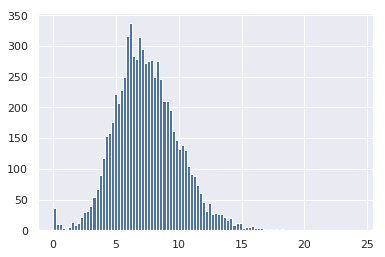

In [52]:
plt.hist(Disease_prevalence_UK_Timeseries[201306]['Ward_Prevalence']['depression'].values(),bins=100)

In [ ]:
boroughMap = {}
for name , group in df.groupby('LAD15NM'):
        boroughMap[name] = list(group['LSOA11CD'])

In [ ]:
# city_prevalence_UK = {}
city_gt_prevalence_UK = {}

for k in wardMap:
    try:
        city_disease_presc = np.sum([LSOA_disease_dosage_count['dementia'][w] for w in wardMap[k] if not np.isnan(LSOA_disease_dosage_count['dementia'][w])])
#         city_patient_pop = np.sum([Ward_patients['DEM'][w] for w in cityMap[k] if not np.isnan(Ward_patients['DEM'][w])])
        city_disease_pop = np.sum([DiseasePop_byWard['DEP'][w] for w in wardMap[k] if not np.isnan(DiseasePop_byWard['DEM'][w])])
#         city_prevalence_UK[k] = float(city_disease_presc)/float(cityPop[k])
        city_gt_prevalence_UK[k] = float(city_disease_pop)/float(cityPop[k])
    except:
        print "Some ward had wrong data"

In [ ]:
len(city_prevalence_UK)

In [ ]:
sns.distplot(city_gt_prevalence_UK.values())

In [ ]:
sns.distplot(city_prevalence_UK['depression'].values())

In [ ]:
commonWards_UK_borough = set(city_prevalence_UK['depression'].keys()).intersection(city_gt_prevalence_UK.keys())

In [ ]:
sns.regplot([ city_prevalence_UK['depression'][k] for k in commonWards_UK_borough],[city_gt_prevalence_UK[k] for k in commonWards_UK_borough])
ax = plt.gca()
ax.set_title("Comparison between prevalences acquired by BNF and Drugbank drug lists")
ax.set_xlabel("Drugbank prevalence")
ax.set_ylabel("BNF prevalence")

In [ ]:
pearsonr([ city_prevalence_UK['depression'][k] for k in commonWards_UK_borough],[city_gt_prevalence_UK[k] for k in commonWards_UK_borough])

In [ ]:
LSOA_disease_drug_count.keys()

In [ ]:
city_prevalence_UK.keys()

In [ ]:
sum(city_all_prescription_count.values())

In [ ]:
# borough_disease_prescription_count['diabetes']

In [ ]:
# borough_prevalence_UK['rheumatoid']

In [ ]:
FinalDisease_prevalence = {'2016Q1':city_prevalence_UK}
with open('Disease_Prevalence_City.json','wb') as f:
    json.dump(FinalDisease_prevalence,f)

In [ ]:
city_prevalence_UK

In [ ]:
symptomList= pd.read_csv("../BL_Work/Dis_sym_edited.csv")
symptomList.head()
normId = {}
for index , row in symptomList.iterrows():
    normId[row['norm_UID'].strip().lower()] = row['UID']

In [ ]:
city_prevalence_Symptom_UK = {}
city_symptom_prescription_count = {}
for d in LSOA_symptom_dosage_count:
    if d not in city_prevalence_Symptom_UK:
        city_symptom_prescription_count[d] = {}
        city_prevalence_Symptom_UK[d] = {}
        city_prevalence_Symptom_UK[d]['Id'] = normId[d]
        city_prevalence_Symptom_UK[d]['prev']={}

        for k in wardMap:
            try:
                city_disease_presc = np.sum([LSOA_symptom_dosage_count[d][w] for w in wardMap[k] if not np.isnan(LSOA_symptom_dosage_count[d][w])])
                city_symptom_prescription_count[d][k] = city_disease_presc
                city_prevalence_Symptom_UK[d]['prev'][k] = float(city_disease_presc)/float(cityPop[k])
            except:
                print "Some ward had wrong data"

In [32]:
len(city_prevalence_Symptom_UK['anxiety']['prev'])

NameError: name 'city_prevalence_Symptom_UK' is not defined

In [ ]:
json.dump(city_prevalence_Symptom_UK,open('2010_Ward_dosage_symptom_prevalence.json','wb'))

In [ ]:
# FinalSymptom_prevalence = {'2016Q1':city_prevalence_Symptom_UK}
# with open('Symptom_Prevalence_city.json','wb') as f:
#     json.dump(FinalSymptom_prevalence,f)

In [ ]:
# confidence_disease = json.load(open('../processed/DiseaseConfidence_V2_352.json','rb'))
# confidence_symptom = json.load(open('../processed/SymtomConfidence_with_normID_349.json','rb'))

In [ ]:

# DiseasePrevalence = FinalDisease_prevalence['2016Q1']
# SymptomPrevalence = FinalSymptom_prevalence['2016Q1']

In [ ]:
DiseasePop_byWard.keys()

In [ ]:
city_prevalence_UK = {}
city_prevalence_dosage_UK = {}
city_gt_prevalence_UK = {}
city_prescription_count = {}
disease_key = 'depression'
survey_key = 'DEP'
for k in tqdm(cityMap):
    try:
        city_disease_presc = np.sum([LSOA_disease_drug_count[disease_key][w] for w in cityMap[k] if not np.isnan(LSOA_disease_drug_count[disease_key][w])])
        city_disease_dosage_presc = np.sum([LSOA_disease_dosage_count[disease_key][w] for w in cityMap[k] if not np.isnan(LSOA_disease_dosage_count[disease_key][w])])
        city_patient_pop = np.sum([Ward_patients[survey_key][w] for w in cityMap[k] if not np.isnan(Ward_patients[survey_key][w])])
        city_disease_pop = np.sum([DiseasePop_byWard[survey_key][w] for w in cityMap[k] if not np.isnan(DiseasePop_byWard[survey_key][w])])
        
        city_prescription_count[k] = city_disease_presc
        city_prevalence_UK[k] = float(city_disease_presc)/float(cityPop[k])
        city_prevalence_dosage_UK[k] = float(city_disease_dosage_presc)/float(cityPop[k])
        city_gt_prevalence_UK[k] = float(city_disease_pop)/float(cityPop[ke
#         city_prevalence_UK[k] = float(city_disease_presc)/city_patient_pop
#         city_prevalence_dosage_UK[k] = float(city_disease_dosage_presc)/city_patient_pop
#         city_gt_prevalence_UK[k] = float(city_disease_pop)/city_patient_pop
    except:
        print("Some ward had wrong data")

In [ ]:
# city_prescription_count

In [ ]:
# json.dump(city_gt_prevalence_UK,open('dementia_survey_gt.json','wb'))

In [ ]:
commonWards_UK_borough = set(city_prevalence_UK.keys()).intersection(city_gt_prevalence_UK.keys())

In [ ]:
len(commonWards_UK_borough)

In [ ]:
city_gt_prevalence_UK

In [ ]:
city_prevalence_UK

In [ ]:
# commonWards_UK_borough = [k for k in commonWards_UK_borough if k != 'Dudley']

In [ ]:
# sns.regplot([ DiseasePrevalence['depression'][k]/100 for k in commonWards_UK_borough],[London_gt[k] for k in commonWards_UK_borough])
# ax = plt.gca()
# ax.set_title("Comparison between prevalences acquired by BNF and Drugbank drug lists")
# ax.set_xlabel("Drugbank prevalence")
# ax.set_ylabel("BNF prevalence")

In [ ]:
# pearsonr([ DiseasePrevalence['depression'][k]  for k in commonWards_UK_borough],[London_gt[k] for k in commonWards_UK_borough])

In [ ]:
# sns.regplot([ DiseasePrevalence['dementia'][k] for k in commonWards_UK_borough],[borough_gt_prevalence_UK[k] for k in commonWards_UK_borough])
# ax = plt.gca()
# ax.set_title("Comparison between prevalences acquired by BNF and Drugbank drug lists")
# ax.set_xlabel("Drugbank prevalence")
# ax.set_ylabel("BNF prevalence")

In [ ]:
pearsonr([ city_prevalence_UK[k] for k in commonWards_UK_borough],[city_gt_prevalence_UK[k] for k in commonWards_UK_borough])

In [ ]:
pearsonr([ city_prevalence_dosage_UK[k] for k in commonWards_UK_borough],[city_gt_prevalence_UK[k] for k in commonWards_UK_borough])

In [ ]:
def label_point(x, y, val, ax ):
    a = pd.concat({'x': pd.Series(x), 'y':  pd.Series(y), 'val': pd.Series(val)}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']),fontsize=12)

def filterHighestResiduals(gt,predict,names , topK):
    slope, intercept, r_value, p_value, std_err = linregress(predict,gt)
    predicted = [(slope*k)+intercept for k in gt]
    residuals = [abs(v1 - v2) for (v1,v2) in zip(predicted,predict)]
    topKidx = np.argsort(residuals)[-topK:][::-1]
    return [gt[i] for i in topKidx] , [predict[i] for i in topKidx], [names[i] for i in topKidx]

predict = []
predict_dose = []
gt = []
names = []
logpop = []
logdosage = [] 
for k in commonWards_UK_borough:
    predict.append(city_prevalence_UK[k]*1000.0)
    predict_dose.append(city_prevalence_dosage_UK[k]*10)#*1000.0)
    names.append(k)
    gt.append(city_gt_prevalence_UK[k]*1000.0)
    logpop.append(np.log(cityPop[k]))
    logdosage.append(np.log(city_prescription_count[k]))

# predict

corr1 = pearsonr(predict,gt)
corr2 = pearsonr(predict_dose,gt)
print corr1 , corr2

In [ ]:
disease_string = 'Dementia'

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.regplot(x=gt , y = predict)
ax = plt.gca()
# gt_ , predict_ , names_ = filterHighestResiduals(gt, predict , names, 10)
label_point(gt , predict , names , ax)
ax.set_title(disease_string ,fontsize=25)
plt.xticks(fontsize = 20 )
plt.yticks(fontsize = 20 )
ax.set_xlabel("Normalized disease prevalence from NHS survey",fontsize=25)
ax.set_ylabel("Normalized prescription items",fontsize=25)
ax.annotate("r = " +  str(corr1[0])[:4], xy=(0.1, 0.8), xycoords='axes fraction',fontsize = 20)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.regplot(x=gt , y = predict_dose)
ax = plt.gca()
# gt_ , predict_ , names_ = filterHighestResiduals(gt, predict , names, 10)
label_point(gt , predict_dose , names , ax)
ax.set_title(disease_string ,fontsize=25)
plt.xticks(fontsize = 20 )
plt.yticks(fontsize = 20 )
ax.set_xlabel("Normalized disease prevalence from NHS survey",fontsize=25)
ax.set_ylabel("Normalized prescription dosage (x 100)",fontsize=25)
ax.annotate("r = " +  str(corr2[0])[:4], xy=(0.1, 0.8), xycoords='axes fraction',fontsize = 20)

In [ ]:
from scipy.stats import linregress

corr = pearsonr(predict, gt)
print corr

slope, intercept, r_value, p_value, std_err = linregress(x=predict,y=gt)

print slope,  intercept , r_value , p_value , std_err

In [ ]:
from scipy.stats import linregress

corr = pearsonr(logpop, logdosage)
print corr

slope, intercept, r_value, p_value, std_err = linregress(x=logpop,y=logdosage)

print slope,  intercept , r_value , p_value , std_err

In [ ]:
r_value**2

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
p = sns.regplot(x=logpop,y=logdosage,ax=ax)
ax.set_xlabel("ln(Population)",fontsize=25)
ax.set_ylabel("ln(Quantity of prescription items)",fontsize=25)
ax.set_title(disease_string,fontsize=25)
plt.xticks(fontsize = 20 )
plt.yticks(fontsize = 20 )
# label_point(logpop , logdosage , names , ax)
ax.annotate(r"$\beta$" +": " +  str(slope)[:4], xy=(0.1, 0.8), xycoords='axes fraction',fontsize = 20)
ax.annotate(r"$R^2$" +": " +  str(r_value**2)[:4], xy=(0.1, 0.7), xycoords='axes fraction',fontsize = 20)